In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# Optional parameter to create and save visualizations
visualize = False

In [3]:
MICU_admits_clean = pd.read_csv('MICU_admits_clean.csv')

In [4]:
# Define label dataframe 
will_readmit = (MICU_admits_clean.future_readmit == 'Yes')
y_df = pd.DataFrame(will_readmit.map({True: 1, False: 0}))
y_df.columns = ['label']

# Define feature dataframe and split into numerical and categorical features
x_df = MICU_admits_clean.drop(['subject_id','hadm_id','admittime','dischtime','first_careunit','last_careunit','readmit_dt','readmit_last_careunit', 'future_readmit', 'next_readmit_dt'], axis = 1)
x_df_cat = x_df[['gender', 'marital_status', 'insurance']].copy()
x_df_num = x_df.drop(['gender', 'marital_status', 'insurance'], axis = 1)

In [5]:
for key in x_df_cat.keys():
    print key

gender
marital_status
insurance


In [7]:
# Scale numerical features
scaled_x_df_num = pd.DataFrame(StandardScaler().fit_transform(x_df_num), columns=x_df_num.keys())

In [8]:
# Find outliers based on 1.5*(Q3-Q1) outlier step
outliers  = []
# For each feature find the data points with extreme high or low values
for feature in scaled_x_df_num.keys():
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(scaled_x_df_num[feature],25)
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(scaled_x_df_num[feature],75)
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    outliers_per_feature = scaled_x_df_num[~((scaled_x_df_num[feature] >= Q1 - step) & (scaled_x_df_num[feature] <= Q3 + step))]
    outliers = outliers + list(outliers_per_feature.index)
outliers.sort()
outliers = list(set(outliers))

# Remove outliers
clean_scaled_x_df_num = scaled_x_df_num.drop(scaled_x_df_num.index[outliers]).reset_index(drop = True)
print('{} outliers removed'.format(len(outliers)))

3899 outliers removed


In [9]:
if visualize:
    # Visualization of numerical feature correlative distributions before scaling and outlier removal 
    fig = pd.scatter_matrix(x_df_num, alpha = 0.3, figsize = (30,30), diagonal = 'kde')
    plt.savefig('figures/scatter_pre.png')
    # Visualization of numerical feature correlative distributions after scaling and outlier removal
    fig = pd.scatter_matrix(clean_scaled_x_df_num, alpha = 0.3, figsize = (30,30), diagonal = 'kde')
    plt.savefig('figures/scatter_post.png')

In [10]:
# Convert categorical features to "One Hot Encoding" vectors
clean_x_df_cat = x_df_cat.drop(x_df_cat.index[outliers]).reset_index(drop = True)
clean_x_df_cat_ohe = pd.get_dummies(clean_x_df_cat, drop_first=True)

In [11]:
# Recombine scaled numerical and encoded categorical features by concatination
x_df = pd.concat([clean_scaled_x_df_num, clean_x_df_cat_ohe], axis = 1)

In [12]:
# Drop outliers from label Dataframe as well
y_df = y_df.drop(y_df.index[outliers]).reset_index(drop = True)

Label value counts and proportions:

In [13]:
print y_df.label.value_counts()
print '\nPositive label proportion: '
print y_df.label.value_counts()/y_df.shape[0]

0    4290
1     605
Name: label, dtype: int64

Positive label proportion: 
0    0.876404
1    0.123596
Name: label, dtype: float64


In [14]:
# Save preprocessed Dataframes to csv
x_df.to_csv('x_df.csv', label=False)
y_df.to_csv('y_df.csv', label=False)

In [15]:
x_df_num.keys()

Index([u'age', u'urea_n_min', u'urea_n_max', u'urea_n_mean', u'platelets_min',
       u'platelets_max', u'platelets_mean', u'magnesium_max', u'albumin_min',
       u'calcium_min', u'resprate_min', u'resprate_max', u'resprate_mean',
       u'glucose_min', u'glucose_max', u'glucose_mean', u'hr_min', u'hr_max',
       u'hr_mean', u'sysbp_min', u'sysbp_max', u'sysbp_mean', u'diasbp_min',
       u'diasbp_max', u'diasbp_mean', u'temp_min', u'temp_max', u'temp_mean',
       u'sapsii', u'sofa'],
      dtype='object')

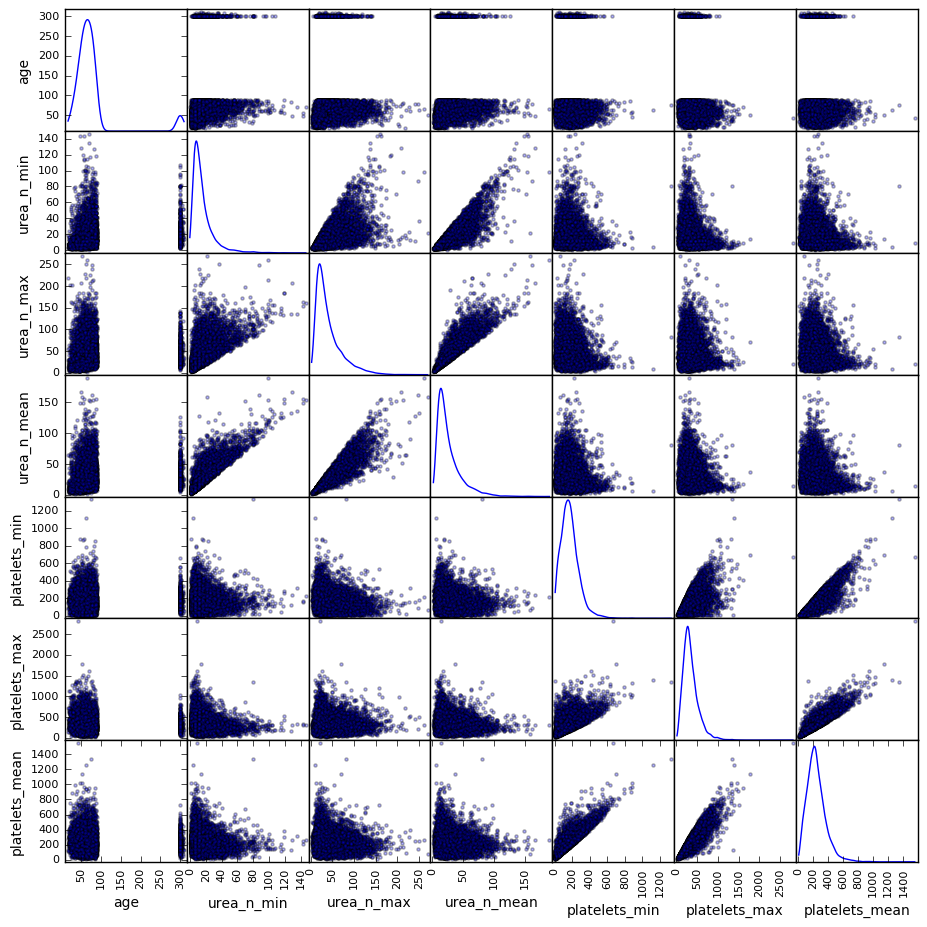

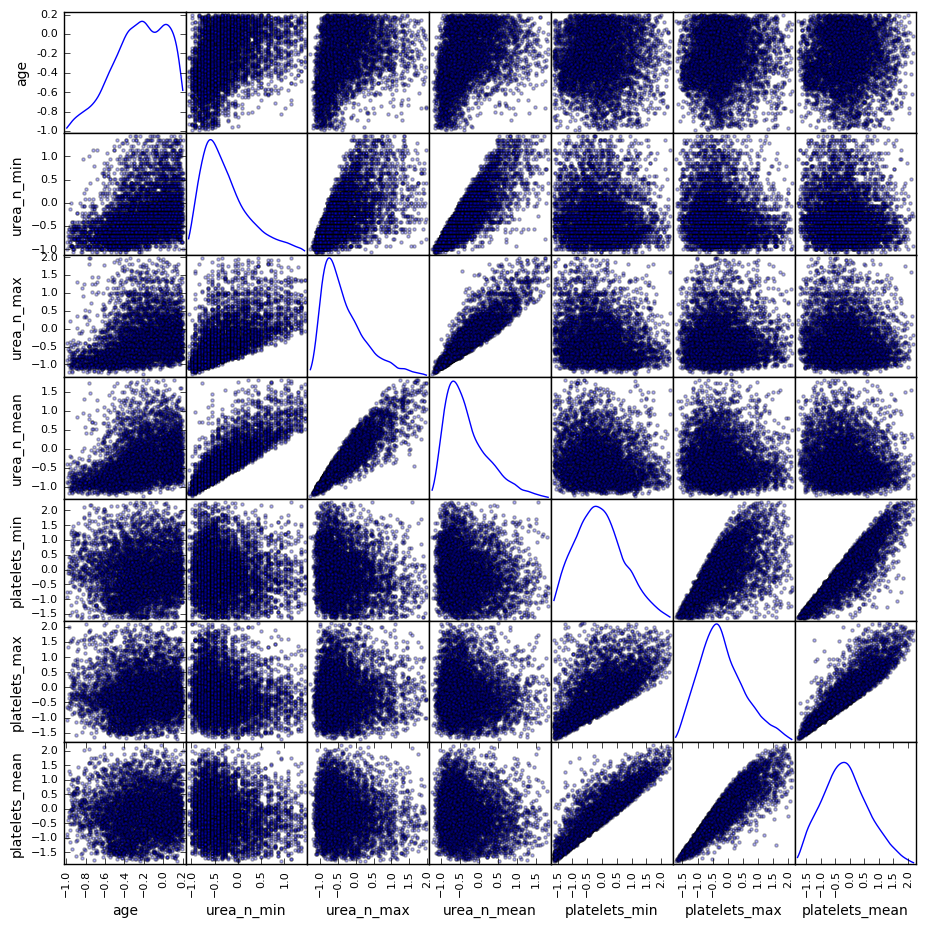

In [16]:
fig1 = pd.scatter_matrix(x_df_num[x_df_num.keys()[0:7]], alpha = 0.3, figsize = (11,11), diagonal = 'kde')
plt.savefig('figures/scatter_detail_pre.png')
fig2 = pd.scatter_matrix(clean_scaled_x_df_num[clean_scaled_x_df_num.keys()[0:7]], alpha = 0.3, figsize = (11,11), diagonal = 'kde')
plt.savefig('figures/scatter_detail_post.png')